In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ipyleaflet import (Map, Marker, basemaps, basemap_to_tiles,
                        FullScreenControl, LayersControl, LayerGroup,
                        WidgetControl, Circle
                       )
from ipywidgets import HTML, Layout, Dropdown, Output, Textarea, VBox, Label
from datamanager import load_wifi_at_location

def classify_wifi_strength(rssi):
    """
    Categories for WiFi RSSI Measurements
        Excellent: x >= -50 dbm
        Good: -50 dbm > x >= -60 dbm 
        Fair: -60 dbm > x >= -70 dbm
        Weak: -70 dbm x
        
    Parameters:
        rssi:integer
            The RSSI value
        
    Returns:
        The category of the WiFi signal strength
    """
    if rssi >= -50: return 'Excellent'
    elif rssi < -50 and rssi >= -60: return 'Good'
    elif rssi < -60 and rssi >= -70: return 'Fair'
    return 'Weak'

STRENGTH_COLOUR = {
    # Blue for Excellent
    'Excellent' : '#0A75F0',
    # Green for Good
    'Good' : '#0AF01D',
    # Yellow for Fair
    'Fair' : '#FFFB08',
    # Red for Weak
    'Weak' : '#FF0C08'
}

In [2]:
james_oval_data = load_wifi_at_location('james')
james_oval_data

,index,lat,lon,time,bssid,quality,rssi,essid
0,0,-31.981019,115.817290,20-09-15-15-54-31,A0:CF:5B:3C:35:9F,0.614286,-67,Unifi
1,1,-31.981019,115.817290,20-09-15-15-54-31,A0:CF:5B:3C:35:90,0.542857,-72,Unifi
2,2,-31.981019,115.817290,20-09-15-15-54-31,7C:21:0E:3E:6A:6F,0.414286,-81,Unifi
3,3,-31.981019,115.817290,20-09-15-15-54-31,A0:CF:5B:3C:2E:B0,0.414286,-81,Unifi
4,4,-31.981019,115.817343,20-09-15-15-54-42,A0:CF:5B:3C:35:9F,0.400000,-82,Unifi
...,...,...,...,...,...,...,...,...
884,147,-31.979758,115.818735,20-09-15-17-30-11,A0:CF:5B:3F:85:0F,0.428571,-80,Unifi
885,148,-31.979758,115.818735,20-09-15-17-30-11,7C:21:0E:3E:68:AF,0.500000,-75,Unifi
886,149,-31.979758,115.818735,20-09-15-17-30-11,70:DF:2F:C6:59:2F,0.357143,-85,Unifi
887,150,-31.979758,115.818735,20-09-15-17-30-11,A0:CF:5B:3C:2E:B0,0.314286,-88,Unifi


In [27]:
class WiFiMap:
    """
    Class for creating maps of WiFi RSSI values and selecting specific Access Points to look at.
    """
    
    
    RADIUS_MODIFIER = 0.5
    CIRCLE_OPACITY = 1.0
    CIRCLE_WEIGHT = 1
    HTML_TEXT = "<b>Showing Access Point:</b> {access_point}"
    
    def __init__(self, wifi_df, length):
        """
        Initialises the WiFiMap class
        
        Parameters:
            wifi_df: pandas.dataframe
                The Dataframe with the WiFi measurements and locations
                
            length: integer
                distance between measurements in dataframe
        """
        self.wifi_df = wifi_df
        self.current_df = wifi_df
        self.length = length
        
        self.best_rssi_layer = LayerGroup(name='RSSI Values')
        
        self.map = Map(
            basemap = basemaps.Esri.WorldImagery,
            center = self.get_average_location(),
            zoom = 100
        )
        
        self.map.add_layer(self.best_rssi_layer)
        self.map.add_control(FullScreenControl())
        self.map.add_control(LayersControl(position='topright'))
        self.create_dropdown()
        
    def create_dropdown(self):
        """
        Creates a dropdown bar for selecting access points to look at
        """
        self.dropdown = Dropdown(
            options = ['All Access Points'] + list(self.wifi_df['bssid'].unique()),
            layout = Layout(width='auto')
        )
        
        self.html = HTML(
            value = WiFiMap.HTML_TEXT.format(access_point = 'All Access Points')
        )
        
        def on_ap_select(change):
            """
            Handler function for updating map and text
            """
            new_ap = self.dropdown.value
            self.html.value = WiFiMap.HTML_TEXT.format(access_point = new_ap)
            if new_ap == 'All Access Points':
                self.current_df = self.wifi_df
            else:
                self.current_df = self.wifi_df.loc[self.wifi_df['bssid'] == new_ap]
            self.update_map()
            
        self.dropdown.observe(on_ap_select, names='value')
        
    def update_map(self):
        """
        Updates the map by plotting all of the points colour coded by best RSSI recording if All Access Points
        is selected.
        
        If the user selects a specific access point then it will just display those points.
        """
        self.best_rssi_layer.clear_layers()
        best_strengths = self.current_df.groupby(['lat', 'lon'])['rssi'].max()
        
        for loc, rssi in best_strengths.items():
            colour = STRENGTH_COLOUR[classify_wifi_strength(rssi)]
            circle = Circle(
                location = loc,
                color = colour,
                fill_color = colour,
                fill_opacity = WiFiMap.CIRCLE_OPACITY,
                radius = int(self.length*WiFiMap.RADIUS_MODIFIER),
                opacity = WiFiMap.CIRCLE_OPACITY,
                weight = WiFiMap.CIRCLE_WEIGHT
            )
            self.best_rssi_layer.add_layer(circle)
    
    def display_map(self):
        """
        Displays the Map and Dropdown bar
        """
        self.update_map()
        return VBox([self.map, self.html, self.dropdown])
        
    def get_average_location(self):
        """
        Gets the Average Location for initialising the graph.
        """
        data_df = self.current_df
        return(data_df['lat'].mean(), data_df['lon'].mean())

In [28]:
james_oval_map = WiFiMap(james_oval_data, 5)
james_oval_map.display_map()

In [29]:
reid_path_data = load_wifi_at_location('reid')
reid_path_map = WiFiMap(reid_path_data, 5)
reid_path_map.display_map()

In [30]:
whitfeld_oval_data = load_wifi_at_location('whitfeld')
whitfeld_oval_map = WiFiMap(whitfeld_oval_data, 5)
whitfeld_oval_map.display_map()

In [31]:
all_data = pd.concat([james_oval_data, reid_path_data, whitfeld_oval_data]).reset_index()
northern_uni_map = WiFiMap(all_data, 5)
northern_uni_map.display_map()

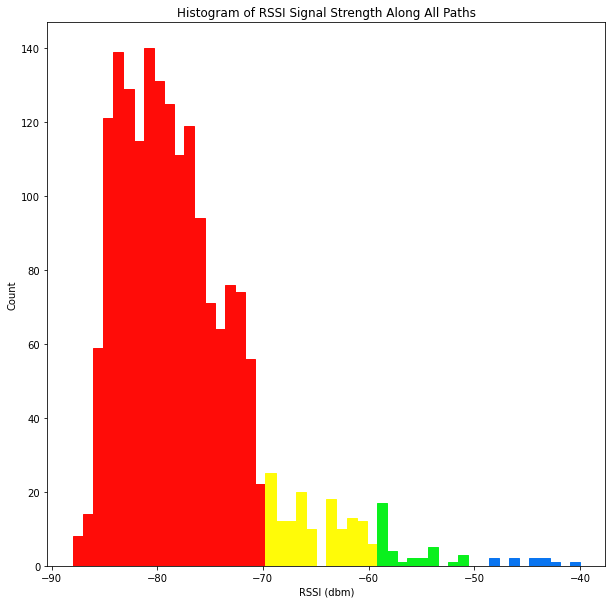

In [32]:
def display_rssi_hist(data, title, x_label, y_label):
    """
    Displays the Histogram of RSSI values in the colour code of Excellent, Good, Fair and Weak
    
    Parameters:
        data: pandas.DataFrame
            the dataframe to plot the RSSI values from
            
        title: str
            the title of the histogram
            
        x_label: str
            the label of the x axis
            
        y_label: str
            the label of the y axis
    """
    rssi_values = data['rssi']
    
    p = rssi_values.plot(kind = 'hist', bins=50, figsize=(10,10))
    
    for i, rectangle in enumerate(p.patches):
        p.patches[i].set_color(STRENGTH_COLOUR[classify_wifi_strength(rectangle.xy[0])])
    
    p.set_title(title)
    p.set_xlabel(x_label)
    p.set_ylabel(y_label)

display_rssi_hist(all_data, 'Histogram of RSSI Signal Strength Along All Paths', 'RSSI (dbm)', 'Count')